# Project IART Class - COVID-19 mobility records - Part 2
## Machine Learning Analysis - Regression problems

We added now a few more data to our dataset, such as: 

 * total cases by 1 Million of population
 * fatalities by 1 Million of population
 * IBP - Internal Brut Product
 * Ranking of the efficience of the health system
 
We hope they help us to make better predictions.

In [25]:
#Main imports
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb
import sys
import os

#Import modules for models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model #linear_model.SGDRegressor()
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn import tree #tree.DecisionTreeRegressor()
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


#Import modules for metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [17]:
code_path=os.getcwd()
data_path=code_path.replace('code','data')
print("Code path : ",code_path)
print("Data path : ",data_path)

Code path :  /home/fatimab/IART_classes/COVID-19/code
Data path :  /home/fatimab/IART_classes/COVID-19/data


In [18]:
os.chdir(data_path)
covid_data=pd.read_csv("data_2.csv",na_values=["NA"])
os.chdir(code_path)
countries_column=np.array(covid_data.loc[:,"country"])
countries=np.unique(countries_column)
days=np.arange(43)
days_column=np.tile(days,countries.shape[0])
covid_data.loc[:,"date"]=days_column
covid_data.head()

,iso,country,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,total_cases_1m,fatalitis_1m,pib,health_system_efficiency
0,AR,Argentina,0,8.185,17.563,0.437,13.644,5.334,-2.486,0,0,0.0,0.0,519487,0.722
1,AR,Argentina,1,-15.875,25.605,6.321,-9.973,-26.785,-53.687,0,0,0.0,0.0,519487,0.722
2,AR,Argentina,2,-17.135,1.325,6.895,-19.717,-28.485,-50.053,0,0,0.0,0.0,519487,0.722
3,AR,Argentina,3,2.304,5.399,-2.273,0.845,9.461,12.584,0,0,0.0,0.0,519487,0.722
4,AR,Argentina,4,-0.404,-5.267,-0.493,-0.584,7.983,12.407,0,0,0.0,0.0,519487,0.722


# Analysis of features
Firstly, let's do a analysis of what data is more important in order to calculate the number of total cases.

## First regression problem: predict total_cases
Let's consider the total_cases for 1 million of population.

In [19]:
cases_previous_7days=[]
for i in range(0,len(covid_data.date)):
  if covid_data.date[i]<=6: 
    cases_previous_7days.append(-1)
  else:
    cases_previous_7days.append(covid_data.total_cases_1m[i-7])

    
cases_previous_7days=np.array(cases_previous_7days)

covid_data["total_cases_7days"]=cases_previous_7days

first_week=(covid_data.total_cases_7days!=-1)
second_data=covid_data[first_week]
second_data=covid_data.reset_index(drop=True)



In [20]:
covid_data.describe()

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,total_cases_1m,fatalitis_1m,pib,health_system_efficiency,total_cases_7days
count,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,8.170000e+02,817.000000,817.000000
mean,21.000000,-8.229424,-13.394035,9.545845,-26.205257,-28.370122,-19.126192,10699.773562,566.007344,144.442749,9.084531,2.618162e+06,0.804053,65.793767
std,12.417275,21.313369,32.891636,10.545377,30.992728,30.211025,25.983021,31656.464952,2008.520488,365.319419,34.593547,4.376739e+06,0.168450,199.956429
min,0.000000,-84.798000,-91.456000,-3.647000,-95.158000,-88.956000,-79.293000,0.000000,0.000000,0.000000,0.000000,3.681350e+05,0.319000,-1.000000
25%,10.000000,-16.578000,-32.841000,0.744000,-49.975000,-54.145000,-40.582000,27.000000,0.000000,0.323912,0.000000,7.712740e+05,0.722000,0.000000
50%,21.000000,0.088000,-6.498000,5.912000,-14.427000,-19.502000,-8.395000,648.000000,6.000000,6.706333,0.084942,1.427533e+06,0.876000,1.167130
75%,32.000000,4.838000,6.961000,16.695000,-0.632000,-0.970000,1.037000,4585.000000,79.000000,102.431506,1.010231,2.718732e+06,0.925000,20.806102
max,42.000000,59.474000,75.002000,40.343000,19.699000,16.822000,21.347000,336912.000000,15887.000000,2795.008348,268.384155,2.058025e+07,0.994000,1700.834957


In [33]:
all_features=covid_data[['grocery_pharmacy','parks','residential','retail_recreation','transit_stations','workplaces','total_cases_7days','pib','health_system_efficiency']].values
all_labels=covid_data['total_cases_1m'].values
all_groups=np.array(covid_data.loc[:,"country"])


print("Features shape : ",all_features.shape)
print("All labels shape : ", all_labels.shape)
print("All groups shape : ", all_groups.shape)

Features shape :  (817, 9)
All labels shape :  (817,)
All groups shape :  (817,)


In [34]:
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

#Define number of splits
n_splits=5

group_kfold=GroupKFold(n_splits=n_splits)
print("Splits", group_kfold.get_n_splits(all_features_2,all_labels_2,all_groups_2))
print(group_kfold)

Splits 5
GroupKFold(n_splits=5)


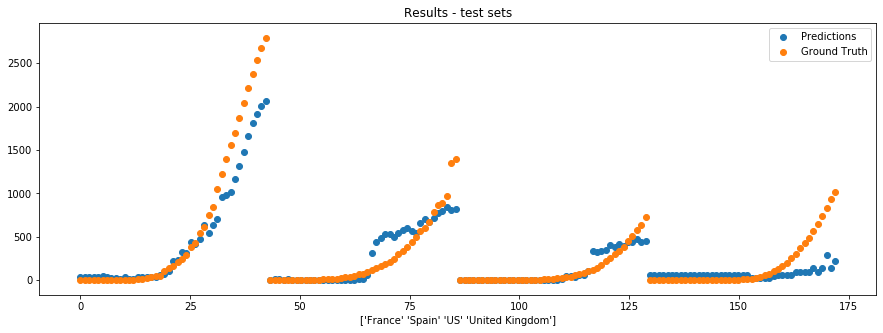

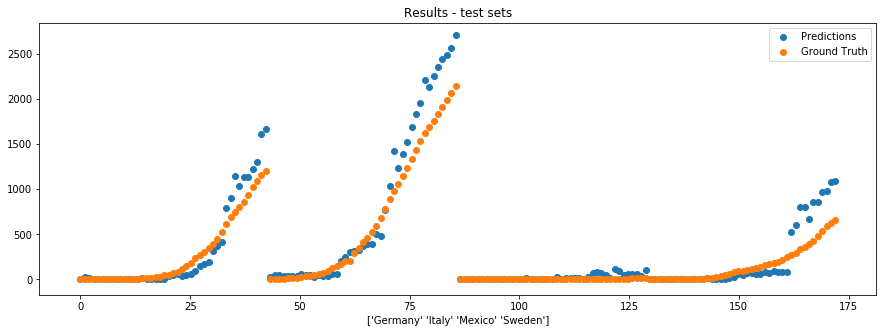

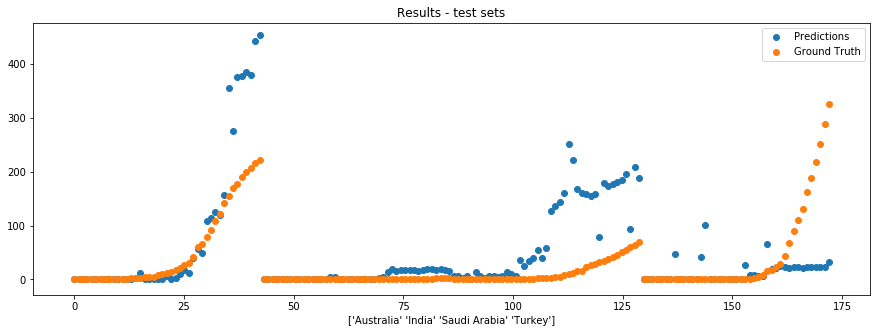

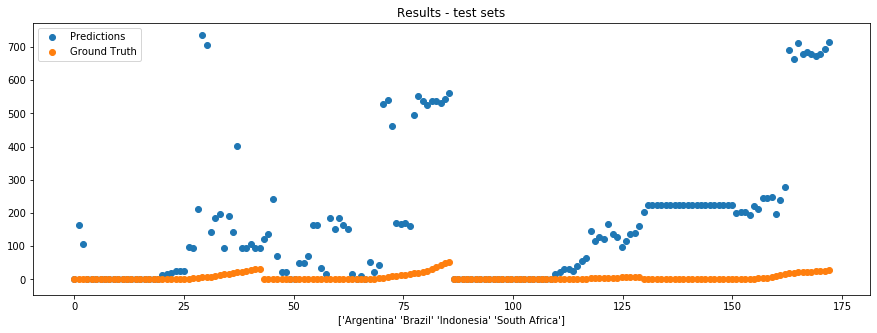

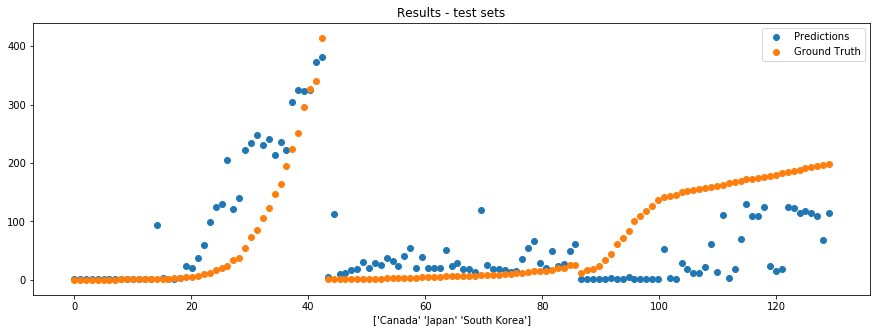

In [35]:
train_r2scores=[]
test_r2scores=[]
train_mse_scores=[]
test_mse_scores=[]
train_maxerror_scores=[]
test_maxerror_scores=[]
train_mae_scores=[]
test_mae_scores=[]

train_r2scores_scaled=[]
test_r2scores_scaled=[]
test_mae_scores_scaled=[]
train_mse_scores_scaled=[]
test_mse_scores_scaled=[]
train_maxerror_scores_scaled=[]
test_maxerror_scores_scaled=[]
train_mae_scores_scaled=[]

for train_idx,test_idx in group_kfold.split(all_features,all_labels,all_groups):
    #Train set
    train_countries=np.unique(np.array(covid_data.loc[train_idx]["country"]))
    X_train=all_features[train_idx]
    y_train=all_labels[train_idx]
    
    #Test & Validation set
    test_countries=np.unique(np.array(covid_data.loc[test_idx]["country"]))
    X_test=all_features[test_idx]
    y_test=all_labels[test_idx]

    #Scaling the data 
    scaler=StandardScaler()    
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    #PCA
    pca=PCA(0.95)
    pca.fit(X_train)
    X_train_PCA=pca.transform(X_train)
    X_test_PCA=pca.transform(X_test)
    
    
    model=RandomForestRegressor()
    #model=tree.DecisionTreeRegressor(max_depth=10)
    #model=MLPRegressor(hidden_layer_sizes=(100,),learning_rate='adaptive',max_iter=500)
    model.fit(X_train_PCA,y_train)
    
    predictions_train=model.predict(X_train_PCA)
    predictions_test=model.predict(X_test_PCA)
    
    #Scale the predicted and label values to [0,1] range
    scaler_l=MinMaxScaler()
    #y
    y_train_scaled=y_train.reshape(-1,1)
    y_train_scaled=scaler_l.fit_transform(y_train_scaled)
    y_train_scaled=y_train_scaled.reshape(-1)
    
    y_test_scaled=y_test.reshape(-1,1)
    y_test_scaled=scaler_l.fit_transform(y_test_scaled)
    y_test_scaled=y_test_scaled.reshape(-1)
    #pred
    predictions_train_scaled=predictions_train.reshape(-1,1)
    predictions_train_scaled=scaler_l.fit_transform(predictions_train_scaled)
    predictions_train_scaled=predictions_train_scaled.reshape(-1)       
    
    predictions_test_scaled=predictions_test.reshape(-1,1)
    predictions_test_scaled=scaler_l.fit_transform(predictions_test_scaled)
    predictions_test_scaled=predictions_test_scaled.reshape(-1)
      
        
    #Calculate values of metrics
    #Non-scaled
    r2_train=r2_score(y_train,predictions_train)
    r2_test=r2_score(y_test,predictions_test)
    
    mse_train=mse(y_train,predictions_train)
    mse_test=mse(y_test,predictions_test)
    
    me_train=max_error(y_train,predictions_train)
    me_test=max_error(y_test,predictions_test)
    
    mae_train=mean_absolute_error(y_train,predictions_train)
    mae_test=mean_absolute_error(y_test,predictions_test)    
    
    #Scaled
    r2_train_scaled=r2_score(y_train_scaled,predictions_train_scaled)
    r2_test_scaled=r2_score(y_test_scaled,predictions_test_scaled)
    
    mse_train_scaled=mse(y_train_scaled,predictions_train_scaled)
    mse_test_scaled=mse(y_test_scaled,predictions_test_scaled)
    
    me_train_scaled=max_error(y_train_scaled,predictions_train_scaled)
    me_test_scaled=max_error(y_test_scaled,predictions_test_scaled)
    
    mae_train_scaled=mean_absolute_error(y_train_scaled,predictions_train_scaled)
    mae_test_scaled=mean_absolute_error(y_test_scaled,predictions_test_scaled)  
    
    
    #Save results
    #Non-scaled
    train_r2scores.append(round(r2_train,4))
    test_r2scores.append(round(r2_test,4))
    
    train_mse_scores.append(round(mse_train,4))
    test_mse_scores.append(round(mse_test,4))
    
    train_maxerror_scores.append(round(me_train,4))
    test_maxerror_scores.append(round(me_test,4))
    
    train_mae_scores.append(round(mae_train,4))
    test_mae_scores.append(round(mae_test,4))
    
    #Scaled
    train_r2scores_scaled.append(round(r2_train_scaled,4))
    test_r2scores_scaled.append(round(r2_test_scaled,4))
    
    train_mse_scores_scaled.append(round(mse_train_scaled,4))
    test_mse_scores_scaled.append(round(mse_test_scaled,4))
    
    train_maxerror_scores_scaled.append(round(me_train_scaled,4))
    test_maxerror_scores_scaled.append(round(me_test_scaled,4))
    
    train_mae_scores_scaled.append(round(mae_train_scaled,4))
    test_mae_scores_scaled.append(round(mae_test_scaled,4))
    
    #Plot unscaled test results
    fig=plt.figure(figsize=(15,5))
    x=np.linspace(0,len(predictions_test),len(predictions_test))
    plt.scatter(x,predictions_test,label="Predictions")
    plt.scatter(x,y_test,label="Ground Truth")
    plt.xlabel(str(test_countries))
    plt.legend()
    plt.title("Results - test sets")
    plt.show()
    
    
results_train=pd.DataFrame(list(zip(train_r2scores,train_r2scores_scaled,train_mse_scores,train_mse_scores_scaled,train_maxerror_scores,train_maxerror_scores_scaled,train_mae_scores,train_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])

results_test=pd.DataFrame(list(zip(test_r2scores,test_r2scores_scaled,test_mse_scores,test_mse_scores_scaled,test_maxerror_scores,test_maxerror_scores_scaled,test_mae_scores,test_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])




In [36]:
results_train

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.9957,0.9961,345.6152,0.0001,154.2307,0.0741,7.6085,0.0034
1,0.9978,0.9980,214.2300,0.0000,109.1991,0.0497,6.6752,0.0022
2,0.9943,0.9886,937.3723,0.0002,218.6338,0.1379,12.8068,0.0062
3,0.9937,0.9918,1016.4396,0.0002,233.0576,0.1272,14.8183,0.0054
4,0.9949,0.9908,787.4051,0.0002,219.1015,0.1312,11.6497,0.0051


In [37]:
results_test

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.8400,0.8844,48239.3668,0.0045,797.2691,0.2657,122.7481,0.0405
1,0.8528,0.9672,35040.2351,0.0017,585.2173,0.1416,107.6287,0.0255
2,-0.6300,0.0719,6248.6047,0.0336,292.1944,0.9264,41.4948,0.0925
3,-598.8345,-0.4043,64569.0518,0.0546,728.5662,0.8727,164.8338,0.1529
4,0.2662,0.2057,5775.7292,0.0365,180.1672,0.4764,55.3898,0.1394


In [44]:
from sklearn.ensemble import ExtraTreesRegressor

#Scaling the data 
scaler=StandardScaler()    
X_train=scaler.fit_transform(all_features)
y_train=(all_labels)


#ExtraTreesClassifier
model_c=ExtraTreesRegressor()
model_c.fit(X_train,y_train)
features_names=['grocery_pharmacy','parks','residential','retail_recreation','transit_stations','workplaces','total_cases_7days','pib','health_system_efficiency']
for i in range(len(features_names)):
    print(features_names[i],model_c.feature_importances_[i])
print(model_c.feature_importances_)



grocery_pharmacy 0.005282107566193783
parks 0.016852166311854808
residential 0.0040080770482445165
retail_recreation 0.0191072168906124
transit_stations 0.03427350662647398
workplaces 0.024063363785904658
total_cases_7days 0.8654215617597394
pib 0.010180590747563329
health_system_efficiency 0.020811409263413235
[0.00528211 0.01685217 0.00400808 0.01910722 0.03427351 0.02406336
 0.86542156 0.01018059 0.02081141]


In [45]:
all_features_2=covid_data[['parks','retail_recreation','transit_stations','workplaces','total_cases_7days','pib','health_system_efficiency']].values


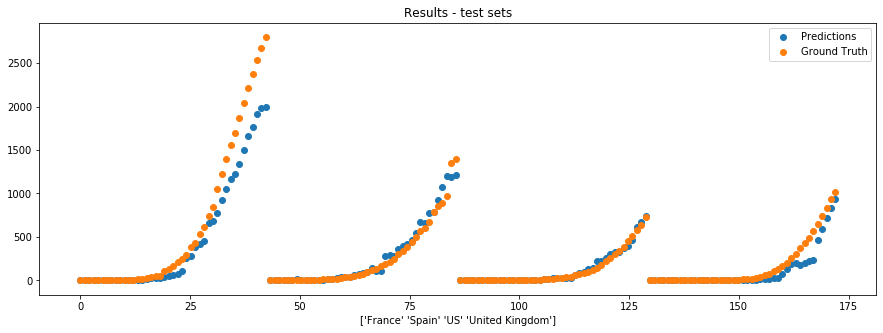

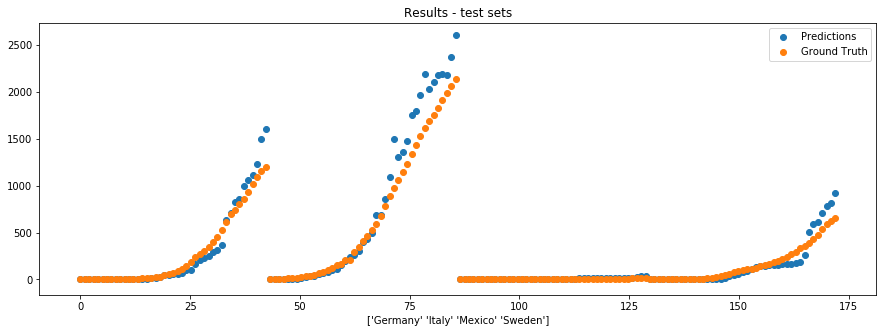

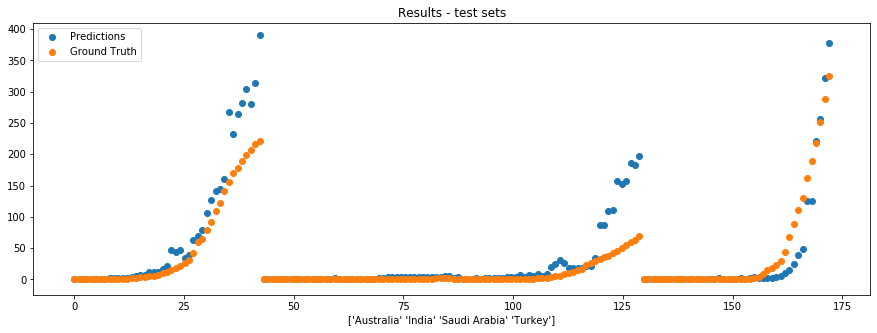

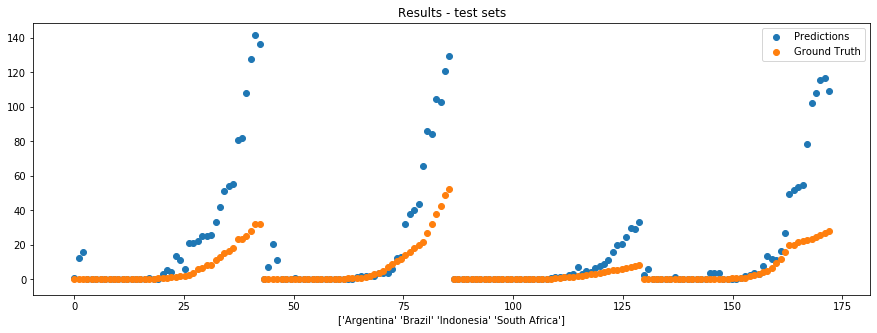

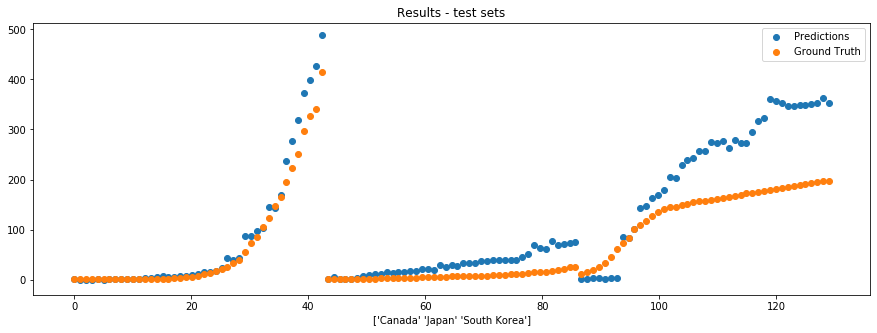

In [47]:


train_r2scores=[]
test_r2scores=[]
train_mse_scores=[]
test_mse_scores=[]
train_maxerror_scores=[]
test_maxerror_scores=[]
train_mae_scores=[]
test_mae_scores=[]

train_r2scores_scaled=[]
test_r2scores_scaled=[]
test_mae_scores_scaled=[]
train_mse_scores_scaled=[]
test_mse_scores_scaled=[]
train_maxerror_scores_scaled=[]
test_maxerror_scores_scaled=[]
train_mae_scores_scaled=[]

for train_idx,test_idx in group_kfold.split(all_features_2,all_labels,all_groups):
    #Train set
    train_countries=np.unique(np.array(covid_data.loc[train_idx]["country"]))
    X_train=all_features[train_idx]
    y_train=all_labels[train_idx]
    
    #Test & Validation set
    test_countries=np.unique(np.array(covid_data.loc[test_idx]["country"]))
    X_test=all_features[test_idx]
    y_test=all_labels[test_idx]

    #Scaling the data 
    scaler=StandardScaler()    
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
        
    model=RandomForestRegressor()
    #model=tree.DecisionTreeRegressor(max_depth=10)
    #model=MLPRegressor(hidden_layer_sizes=(100,),learning_rate='adaptive',max_iter=500)
    model.fit(X_train,y_train)
    
    predictions_train=model.predict(X_train)
    predictions_test=model.predict(X_test)
    
    #Scale the predicted and label values to [0,1] range
    scaler_l=MinMaxScaler()
    #y
    y_train_scaled=y_train.reshape(-1,1)
    y_train_scaled=scaler_l.fit_transform(y_train_scaled)
    y_train_scaled=y_train_scaled.reshape(-1)
    
    y_test_scaled=y_test.reshape(-1,1)
    y_test_scaled=scaler_l.fit_transform(y_test_scaled)
    y_test_scaled=y_test_scaled.reshape(-1)
    #pred
    predictions_train_scaled=predictions_train.reshape(-1,1)
    predictions_train_scaled=scaler_l.fit_transform(predictions_train_scaled)
    predictions_train_scaled=predictions_train_scaled.reshape(-1)       
    
    predictions_test_scaled=predictions_test.reshape(-1,1)
    predictions_test_scaled=scaler_l.fit_transform(predictions_test_scaled)
    predictions_test_scaled=predictions_test_scaled.reshape(-1)
      
        
    #Calculate values of metrics
    #Non-scaled
    r2_train=r2_score(y_train,predictions_train)
    r2_test=r2_score(y_test,predictions_test)
    
    mse_train=mse(y_train,predictions_train)
    mse_test=mse(y_test,predictions_test)
    
    me_train=max_error(y_train,predictions_train)
    me_test=max_error(y_test,predictions_test)
    
    mae_train=mean_absolute_error(y_train,predictions_train)
    mae_test=mean_absolute_error(y_test,predictions_test)    
    
    #Scaled
    r2_train_scaled=r2_score(y_train_scaled,predictions_train_scaled)
    r2_test_scaled=r2_score(y_test_scaled,predictions_test_scaled)
    
    mse_train_scaled=mse(y_train_scaled,predictions_train_scaled)
    mse_test_scaled=mse(y_test_scaled,predictions_test_scaled)
    
    me_train_scaled=max_error(y_train_scaled,predictions_train_scaled)
    me_test_scaled=max_error(y_test_scaled,predictions_test_scaled)
    
    mae_train_scaled=mean_absolute_error(y_train_scaled,predictions_train_scaled)
    mae_test_scaled=mean_absolute_error(y_test_scaled,predictions_test_scaled)  
    
    
    #Save results
    #Non-scaled
    train_r2scores.append(round(r2_train,4))
    test_r2scores.append(round(r2_test,4))
    
    train_mse_scores.append(round(mse_train,4))
    test_mse_scores.append(round(mse_test,4))
    
    train_maxerror_scores.append(round(me_train,4))
    test_maxerror_scores.append(round(me_test,4))
    
    train_mae_scores.append(round(mae_train,4))
    test_mae_scores.append(round(mae_test,4))
    
    #Scaled
    train_r2scores_scaled.append(round(r2_train_scaled,4))
    test_r2scores_scaled.append(round(r2_test_scaled,4))
    
    train_mse_scores_scaled.append(round(mse_train_scaled,4))
    test_mse_scores_scaled.append(round(mse_test_scaled,4))
    
    train_maxerror_scores_scaled.append(round(me_train_scaled,4))
    test_maxerror_scores_scaled.append(round(me_test_scaled,4))
    
    train_mae_scores_scaled.append(round(mae_train_scaled,4))
    test_mae_scores_scaled.append(round(mae_test_scaled,4))
    
    #Plot unscaled test results
    fig=plt.figure(figsize=(15,5))
    x=np.linspace(0,len(predictions_test),len(predictions_test))
    plt.scatter(x,predictions_test,label="Predictions")
    plt.scatter(x,y_test,label="Ground Truth")
    plt.xlabel(str(test_countries))
    plt.legend()
    plt.title("Results - test sets")
    plt.show()
    
    
results_train=pd.DataFrame(list(zip(train_r2scores,train_r2scores_scaled,train_mse_scores,train_mse_scores_scaled,train_maxerror_scores,train_maxerror_scores_scaled,train_mae_scores,train_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])

results_test=pd.DataFrame(list(zip(test_r2scores,test_r2scores_scaled,test_mse_scores,test_mse_scores_scaled,test_maxerror_scores,test_maxerror_scores_scaled,test_mae_scores,test_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])




In [48]:
results_train

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.9987,0.9964,104.5863,0.0001,109.9116,0.0719,3.7932,0.0029
1,0.9974,0.9951,258.3375,0.0001,157.6403,0.0631,5.4614,0.0027
2,0.9970,0.9953,487.0750,0.0001,198.2908,0.0769,8.3853,0.0039
3,0.9970,0.9934,483.0297,0.0001,175.7570,0.1033,8.6175,0.0047
4,0.9970,0.9938,471.4288,0.0001,209.6725,0.1156,7.6045,0.0040


In [49]:
results_test

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.9188,0.9400,24487.2705,0.0023,803.4763,0.2532,70.9957,0.0254
1,0.9295,0.9832,16775.9615,0.0009,574.2821,0.1183,63.2953,0.0174
2,0.6617,0.8163,1296.7809,0.0066,168.7086,0.3202,16.8509,0.0378
3,-6.0055,0.8139,754.1049,0.0072,109.1566,0.3865,13.0275,0.0417
4,0.4384,0.7609,4420.2934,0.0110,181.5783,0.3070,43.2639,0.0673
